# OBTAIN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import warnings
import itertools
import statsmodels.api as sm
import tensorflow.keras as keras
import seaborn as sns
import tensorflow as tf
import gc

from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.metrics import *
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from numpy import array

%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pd.options.display.float_format = '{:.2f}'.format

# SCRUB

## Data IHSG

In [ ]:
# Load IHSG data CSV file
ihsg = pd.read_csv("/content/drive/MyDrive/SKRIPSI2024/new_ihsg.csv")
ihsg

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-01-02,691.38,704.50,688.00,704.50,704.47,11244500.00
1,2004-01-05,706.37,725.47,706.37,725.47,725.44,35915500.00
2,2004-01-06,728.72,738.16,717.83,723.99,723.96,39797000.00
3,2004-01-07,723.91,723.92,705.84,709.37,709.34,33583800.00
4,2004-01-08,709.36,730.82,709.36,730.82,730.79,31361400.00
...,...,...,...,...,...,...,...
5088,2024-07-24,7298.51,7311.15,7249.28,7262.76,7262.76,149278800.00
5089,2024-07-25,7264.21,7268.05,7207.82,7240.28,7240.28,125922000.00
5090,2024-07-26,7262.13,7298.96,7256.53,7288.17,7288.17,128745600.00
5091,2024-07-29,7304.60,7333.90,7274.25,7288.90,7288.90,131946800.00


In [ ]:
# Drop columns
ihsg = ihsg.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])

# Convert the 'Date' column to datetime format
ihsg['Date'] = pd.to_datetime(ihsg['Date'])

# Set the 'Date' column as the index
ihsg.set_index('Date', inplace=True)

In [ ]:
describe_close = ihsg.describe()

In [ ]:
missing_values = ihsg.isnull().sum()

In [ ]:
describe_close, missing_values

(        Close
 count 4996.00
 mean  4246.53
 std   2004.65
 min    668.48
 25%   2382.70
 50%   4601.67
 75%   6009.06
 max   7433.31,
 Close    97
 dtype: int64)

In [ ]:
ihsg = ihsg.dropna(subset=['Close'])
ihsg

,Close
Date,
2004-01-02,704.50
2004-01-05,725.47
2004-01-06,723.99
2004-01-07,709.37
2004-01-08,730.82
...,...
2024-07-24,7262.76
2024-07-25,7240.28
2024-07-26,7288.17


In [ ]:
# Calculate the monthly average of the 'Close' values
monthly_average_close = ihsg['Close'].resample('M').mean()

In [ ]:
monthly_average_close

,Close
Date,
2004-01-31,753.23
2004-02-29,767.55
2004-03-31,745.39
2004-04-30,787.20
2004-05-31,726.21
...,...
2024-03-31,7339.20
2024-04-30,7165.03
2024-05-31,7154.31


## Data Kurs

In [ ]:
# Load Kurs data CSV file
kurs = pd.read_csv("/content/drive/MyDrive/SKRIPSI2024/new_kurs.csv", sep=";")
kurs

,Date,Kurs Dollar
0,2024-07-31,16320.00
1,2024-07-30,16286.00
2,2024-07-29,16294.00
3,2024-07-26,16268.00
4,2024-07-25,16224.00
...,...,...
5033,2004-01-07,8348.00
5034,2004-01-06,8365.00
5035,2004-01-05,8432.00
5036,2004-01-02,8454.00


In [ ]:
# Convert the 'Date' column to datetime format
kurs['Date'] = pd.to_datetime(kurs['Date'])

# Set the 'Date' column as the index
kurs.set_index('Date', inplace=True)

In [ ]:
describe_kurs = kurs.describe()

In [ ]:
missing_values_kurs = kurs.isnull().sum()

In [ ]:
describe_kurs, missing_values_kurs

(       Kurs Dollar
 count      5038.00
 mean      11819.52
 std        2467.74
 min        8323.00
 25%        9265.00
 50%       11874.50
 75%       14164.00
 max       16741.00,
 Kurs Dollar    0
 dtype: int64)

In [ ]:
# Calculate the monthly average of the 'Kurs Dollar' values
monthly_average_kurs = kurs['Kurs Dollar'].resample('M').mean()
monthly_average_kurs

,Kurs Dollar
Date,
2004-01-31,8394.95
2004-02-29,8425.17
2004-03-31,8568.82
2004-04-30,8608.25
2004-05-31,8965.32
...,...
2024-03-31,15702.61
2024-04-30,16100.00
2024-05-31,16083.94


## Validasi Data

In [ ]:
data_close = ihsg.copy()

In [ ]:
data_close['close_monthly'] = data_close['Close'].resample('M').transform('mean')

data_close['close_monthly'].fillna(method='ffill', inplace=True)

data_close

,Close,close_monthly
Date,,
2004-01-02,704.50,753.23
2004-01-05,725.47,753.23
2004-01-06,723.99,753.23
2004-01-07,709.37,753.23
2004-01-08,730.82,753.23
...,...,...
2024-07-24,7262.76,7257.83
2024-07-25,7240.28,7257.83
2024-07-26,7288.17,7257.83


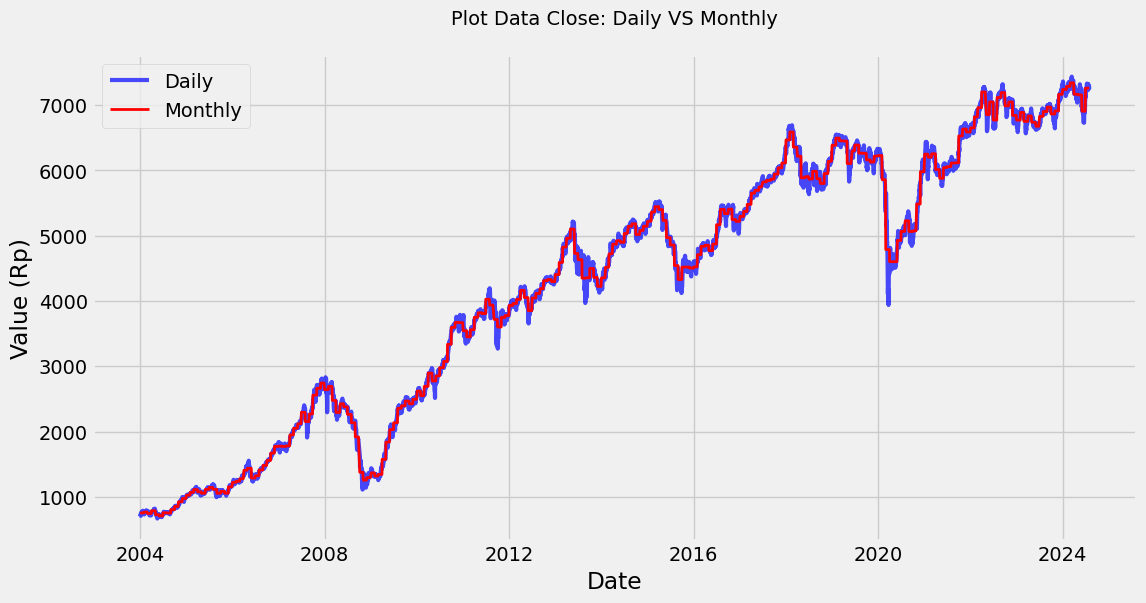

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(data_close['Close'], color='blue', linewidth=3, label='Daily', alpha=0.7)
plt.plot(data_close['close_monthly'], color='red', linewidth=2, label='Monthly')
plt.xlabel('Date')
plt.ylabel('Value (Rp)')
plt.title('Plot Data Close: Daily VS Monthly\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# Correlation Test
correlation_close = data_close.corr()
correlation_close

,Close,close_monthly
Close,1.00000,0.99916
close_monthly,0.99916,1.00000


In [ ]:
data_kurs = kurs.copy()

In [ ]:
data_kurs['kurs_monthly'] = data_kurs['Kurs Dollar'].resample('M').transform('mean')

data_kurs['kurs_monthly'].fillna(method='ffill', inplace=True)

data_kurs

,Kurs Dollar,kurs_monthly
Date,,
2024-07-31,16320.00000,16261.65217
2024-07-30,16286.00000,16261.65217
2024-07-29,16294.00000,16261.65217
2024-07-26,16268.00000,16261.65217
2024-07-25,16224.00000,16261.65217
...,...,...
2004-01-07,8348.00000,8394.95238
2004-01-06,8365.00000,8394.95238
2004-01-05,8432.00000,8394.95238


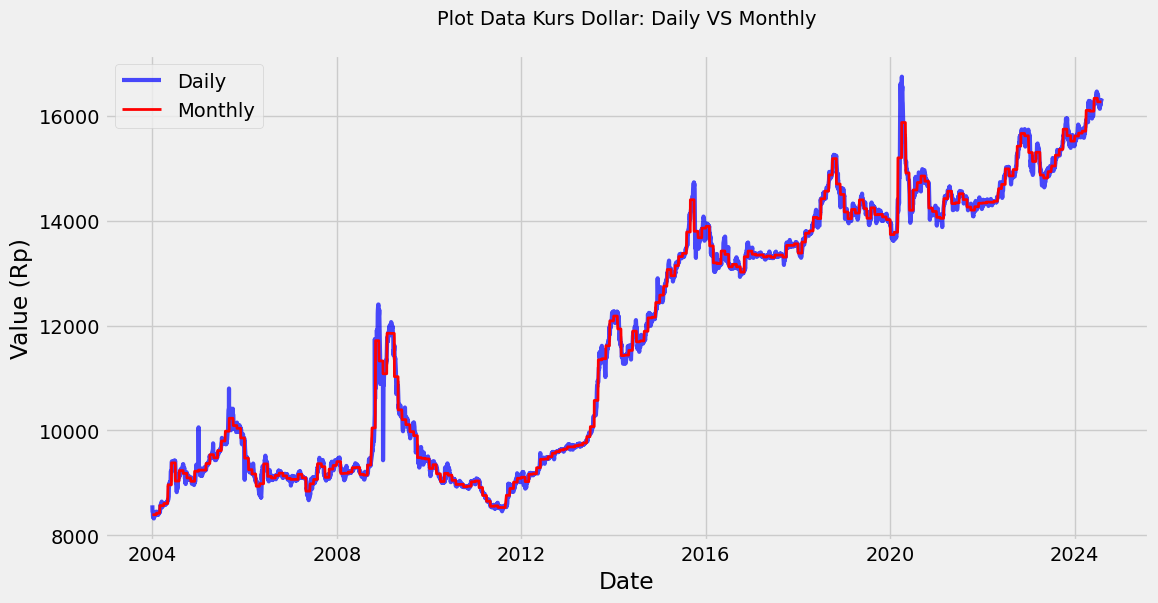

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(data_kurs['Kurs Dollar'], color='blue', linewidth=3, label='Daily', alpha=0.7)
plt.plot(data_kurs['kurs_monthly'], color='red', linewidth=2, label='Monthly')
plt.xlabel('Date')
plt.ylabel('Value (Rp)')
plt.title('Plot Data Kurs Dollar: Daily VS Monthly\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# Correlation Test
correlation_kurs = data_kurs.corr()
correlation_kurs

,Kurs Dollar,kurs_monthly
Kurs Dollar,1.00000,0.99854
kurs_monthly,0.99854,1.00000


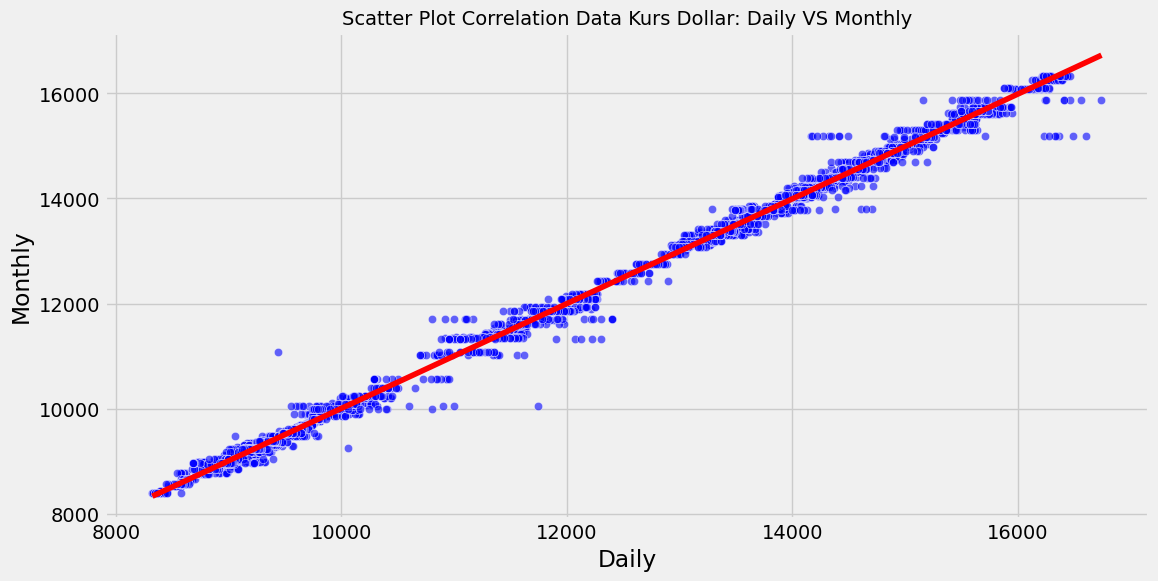

In [ ]:
# Scatterplot Correlation
plt.figure(figsize=(12, 6))
sns.scatterplot(x="Kurs Dollar", y="kurs_monthly", data=data_kurs, color='blue', alpha=0.6)
sns.regplot(x="Kurs Dollar", y="kurs_monthly", data=data_kurs, scatter=False, color='red', line_kws={"linewidth":4})
plt.title('Scatter Plot Correlation Data Close & Kurs Dollar', fontsize=14)
plt.xlabel('Daily')
plt.ylabel('Monthly')
plt.title('Scatter Plot Correlation Data Kurs Dollar: Daily VS Monthly', fontsize=14)
plt.grid(True)
plt.show()

## Merge Data

In [ ]:
# Merge dataframes on 'Date'
df_merge = pd.merge(monthly_average_close,
                    monthly_average_kurs,
                    on='Date',
                    how='inner')

# Display the merged dataframe
df_merge

,Close,Kurs Dollar
Date,,
2004-01-31,753.23,8394.95
2004-02-29,767.55,8425.17
2004-03-31,745.39,8568.82
2004-04-30,787.20,8608.25
2004-05-31,726.21,8965.32
...,...,...
2024-03-31,7339.20,15702.61
2024-04-30,7165.03,16100.00
2024-05-31,7154.31,16083.94


In [ ]:
steps_slicing = 7
df_final = df_merge[:-steps_slicing]
df_update = df_merge[-steps_slicing:]

In [ ]:
df_final

,Close,Kurs Dollar
Date,,
2004-01-31,753.23,8394.95
2004-02-29,767.55,8425.17
2004-03-31,745.39,8568.82
2004-04-30,787.20,8608.25
2004-05-31,726.21,8965.32
...,...,...
2023-08-31,6899.06,15245.14
2023-09-30,6967.65,15354.20
2023-10-31,6861.98,15741.23


In [ ]:
df_update

,Close,Kurs Dollar
Date,,
2024-01-31,7238.07,15610.82
2024-02-29,7284.16,15665.33
2024-03-31,7339.20,15702.61
2024-04-30,7165.03,16100.00
2024-05-31,7154.31,16083.94
2024-06-30,6904.72,16329.39
2024-07-31,7257.83,16261.65


# EXPLORE

## Time Series Plot

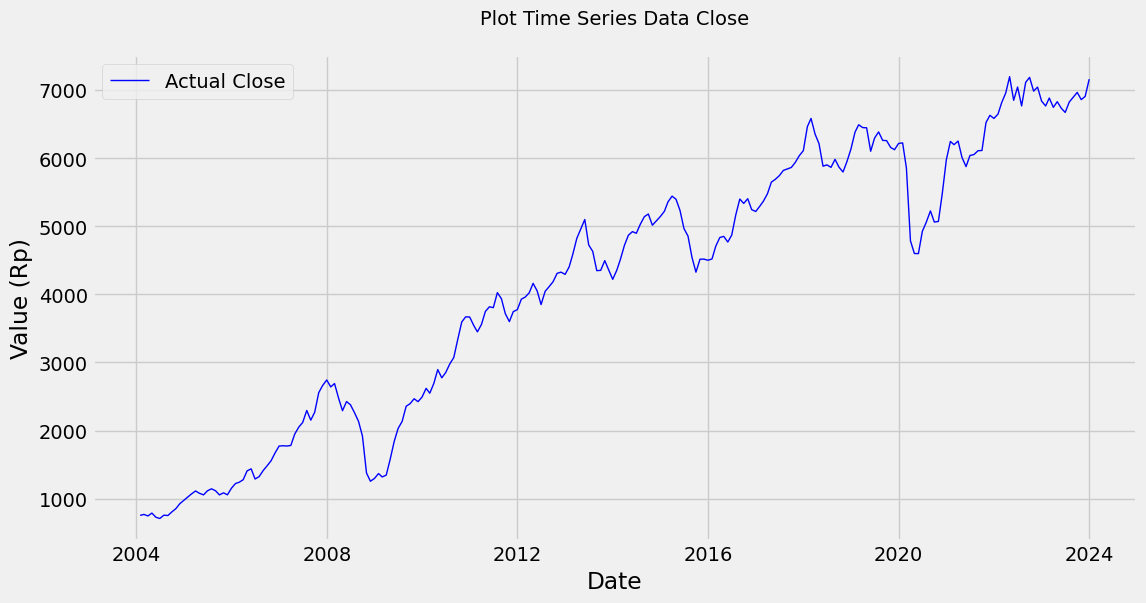

In [ ]:
# Plot the 'Close' data with additional plot details
plt.figure(figsize=(12, 6))
plt.plot(df_final['Close'], color='blue', linewidth=1, label='Actual Close')
plt.xlabel('Date')
plt.ylabel('Value (Rp)')
plt.title('Plot Time Series Data Close\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

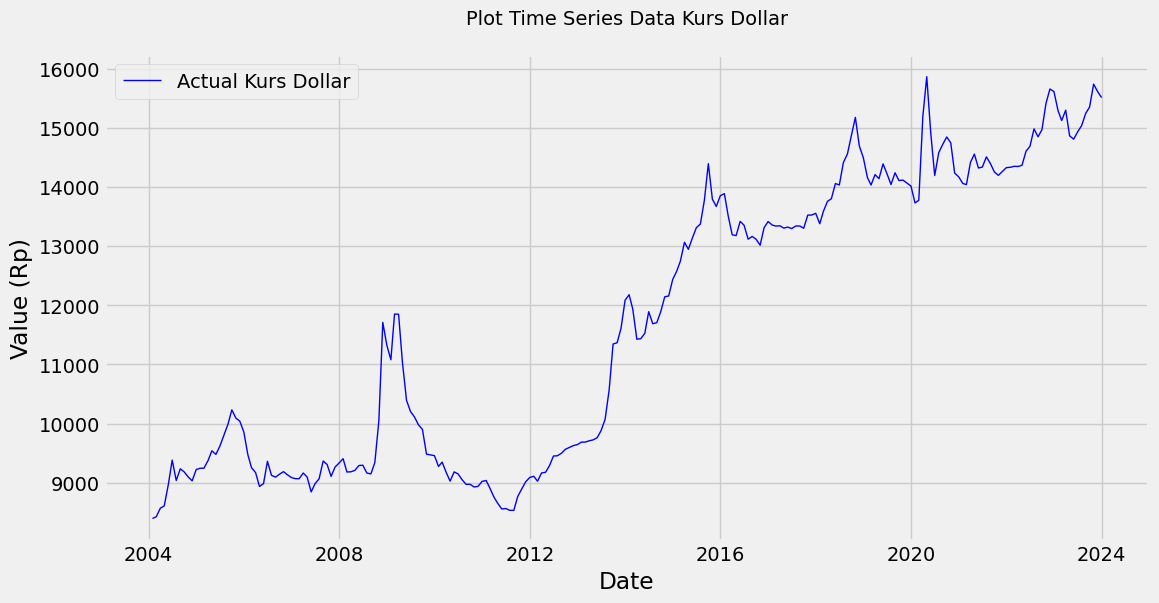

In [ ]:
# Plot the 'Close' data with additional plot details
plt.figure(figsize=(12, 6))
plt.plot(df_final['Kurs Dollar'], color='blue', linewidth=1, label='Actual Kurs Dollar')
plt.xlabel('Date')
plt.ylabel('Value (Rp)')
plt.title('Plot Time Series Data Kurs Dollar\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

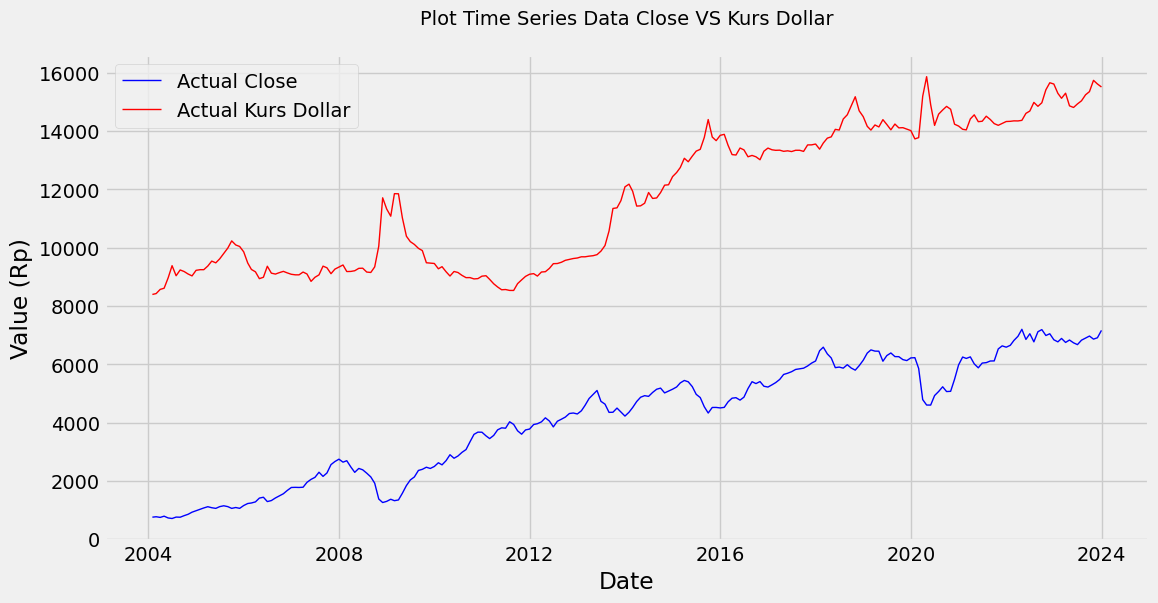

In [ ]:
# Plot the 'Close VS Kurs Dollar' data with additional plot details
plt.figure(figsize=(12, 6))
plt.plot(df_final['Close'], color='blue', linewidth=1, label='Actual Close')
plt.plot(df_final['Kurs Dollar'], color='red', linewidth=1, label='Actual Kurs Dollar')
plt.xlabel('Date')
plt.ylabel('Value (Rp)')
plt.title('Plot Time Series Data Close VS Kurs Dollar\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# Trend and Seasonal Decomposition for 'Close'
result_close = seasonal_decompose(df_final['Close'], model='multiplicative', period=12)

# Trend and Seasonal Decomposition for 'Kurs Dollar'
result_kurs = seasonal_decompose(df_final['Kurs Dollar'], model='multiplicative', period=12)

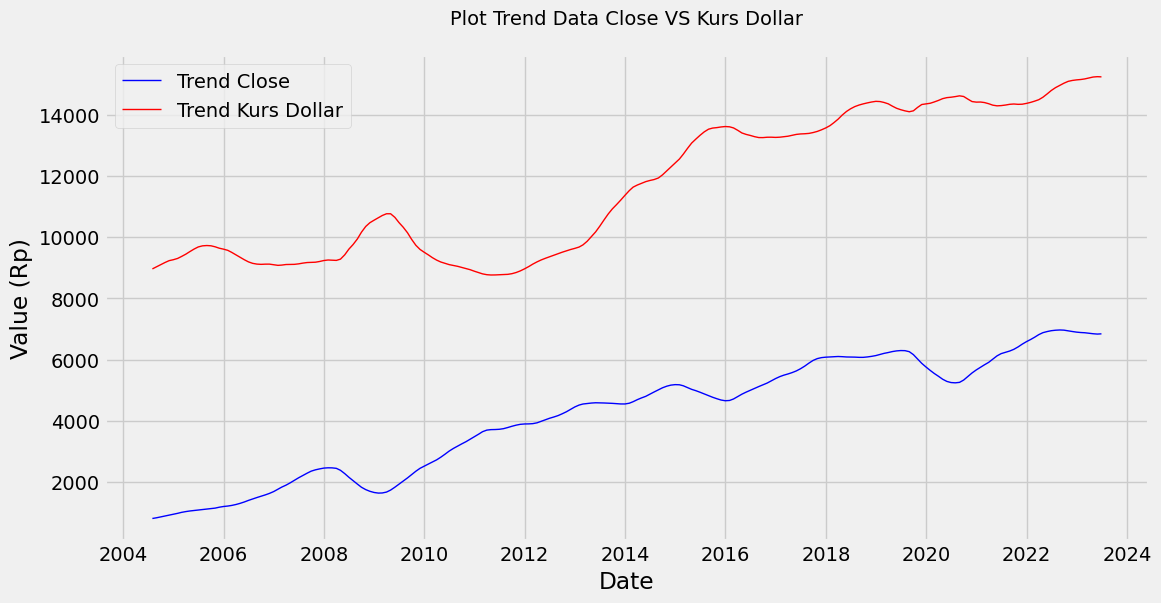

In [ ]:
# Plotting only Trend components
plt.figure(figsize=(12, 6))
plt.plot(result_close.trend, label='Trend Close', color='blue', linewidth=1)
plt.plot(result_kurs.trend, label='Trend Kurs Dollar', color='red', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Value (Rp)')
plt.title('Plot Trend Data Close VS Kurs Dollar\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

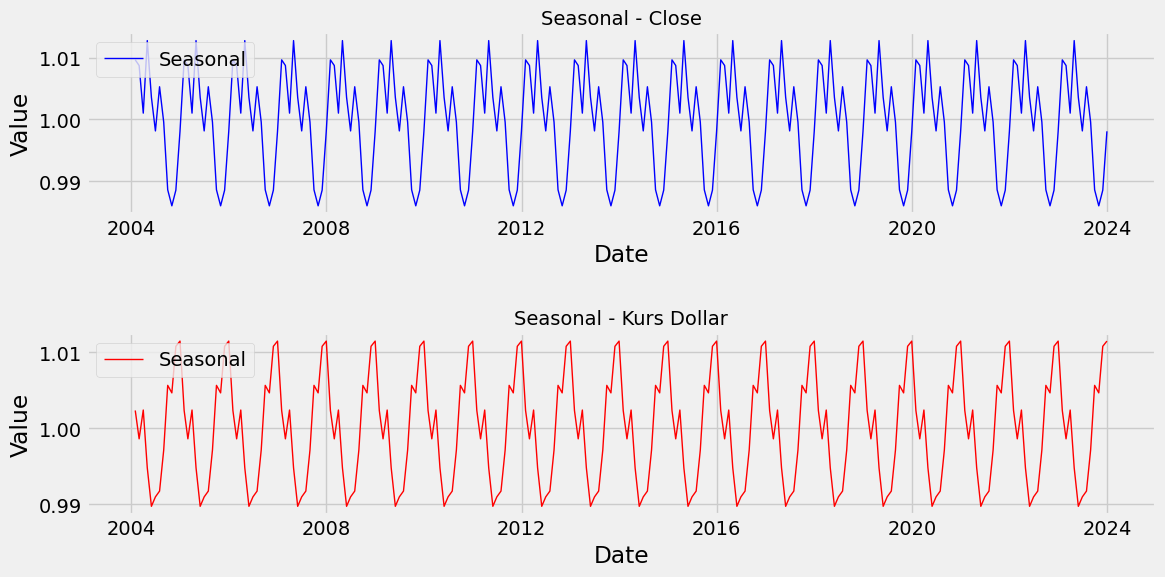

In [ ]:
# Plotting only Seasonal components
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(result_close.seasonal, label='Seasonal', color='blue', linewidth=1)
plt.title('Seasonal - Close', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(result_kurs.seasonal, label='Seasonal', color='red', linewidth=1)
plt.title('\nSeasonal - Kurs Dollar', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Correlation

In [ ]:
data = df_final.copy()

In [ ]:
# Correlation test
correlation = df_final.corr()
correlation

,Close,Kurs Dollar
Close,1.00,0.84
Kurs Dollar,0.84,1.00


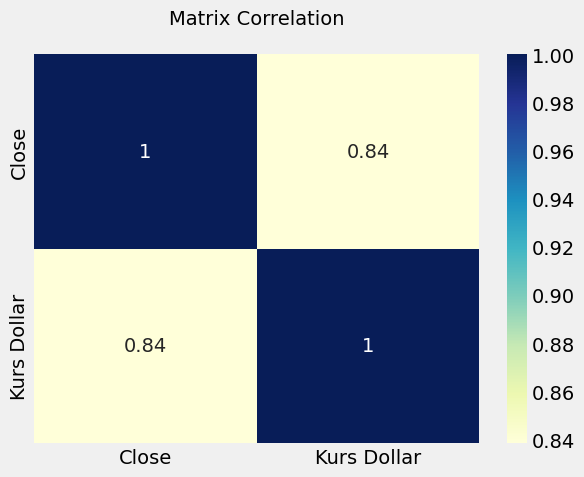

In [ ]:
sns.heatmap(correlation, annot=True, cmap="YlGnBu")
plt.title('Matrix Correlation\n', fontsize = 14)
plt.show()

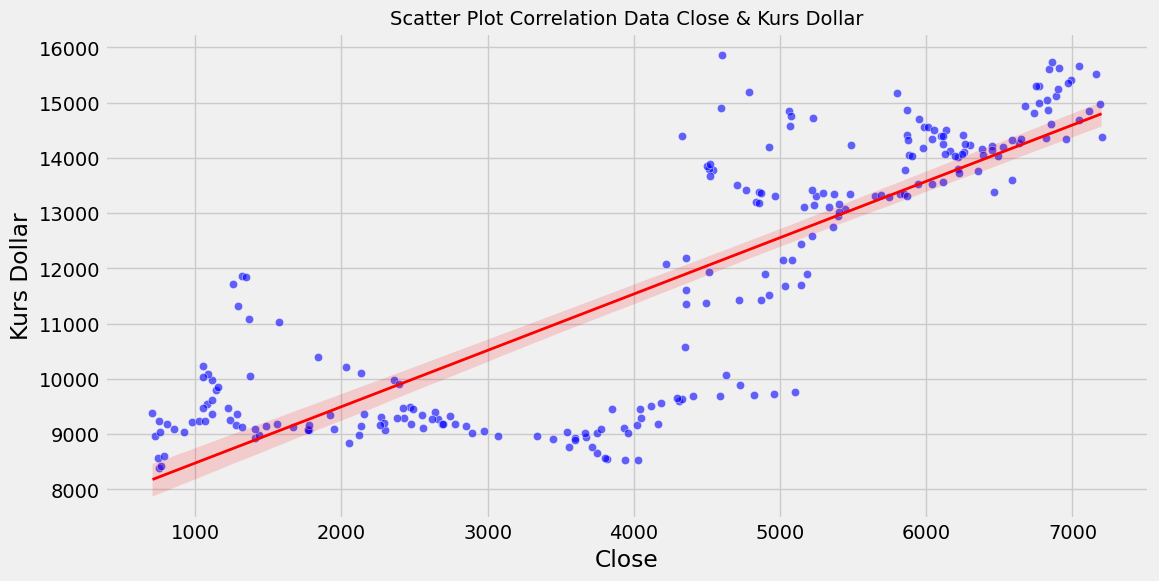

In [ ]:
# Scatterplot Correlation
plt.figure(figsize=(12, 6))
sns.scatterplot(x="Close", y="Kurs Dollar", data=df_final, color='blue', alpha=0.6)
sns.regplot(x="Close", y="Kurs Dollar", data=df_final, scatter=False, color='red', line_kws={"linewidth":2})
plt.title('Scatter Plot Correlation Data Close & Kurs Dollar', fontsize=14)
plt.grid(True)
plt.show()

## Coint Johansen

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Cointegration test using Johansen's method
def johansen_test(data, det_order=-1, k_ar_diff=1):
    return coint_johansen(data, det_order, k_ar_diff)

coint_test = johansen_test(data[['Close', 'Kurs Dollar']])

# Prepare the Johansen test result for display
coint_result_df = pd.DataFrame({
    'Eigenvalue': coint_test.eig,
    'Trace Statistic': coint_test.lr1,
    '5% Critical Value': coint_test.cvt[:, 1]
})

coint_result_df

,Eigenvalue,Trace Statistic,5% Critical Value
0,0.05,17.39,12.32
1,0.02,4.69,4.13


## Augmented Dickey-Fuller

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Function to perform the Augmented Dickey-Fuller test
def adf_test(series, signif=0.05):
    r = adfuller(series, autolag='AIC')
    return r[1] <= signif, r

# Check if data is stationary, if not make it stationary by differencing
is_stationary_close, adf_close = adf_test(data['Close'])
is_stationary_kurs, adf_kurs = adf_test(data['Kurs Dollar'])

# Display ADF test results
adf_close_results = {
    'Test Statistic': adf_close[0],
    'p-value': adf_close[1],
    'Critical Values': adf_close[4]
}

adf_kurs_results = {
    'Test Statistic': adf_kurs[0],
    'p-value': adf_kurs[1],
    'Critical Values': adf_kurs[4]
}

(is_stationary_close, adf_close_results), (is_stationary_kurs, adf_kurs_results)

((False,
  {'Test Statistic': -0.9588307364821751,
   'p-value': 0.7679822623318415,
   'Critical Values': {'1%': -3.4593607492757554,
    '5%': -2.8743015807562924,
    '10%': -2.5735714042782396}}),
 (False,
  {'Test Statistic': -0.7123381890426069,
   'p-value': 0.8435277318326493,
   'Critical Values': {'1%': -3.4583663275730476,
    '5%': -2.8738660999177132,
    '10%': -2.5733390785693766}}))

In [ ]:
# Differencing to make data stationary
data_diff = data.diff().dropna()

# Re-check if data is stationary after differencing
is_stationary_close_diff, adf_close_diff = adf_test(data_diff['Close'])
is_stationary_kurs_diff, adf_kurs_diff = adf_test(data_diff['Kurs Dollar'])

# Display ADF test results after differencing
adf_close_diff_results = {
    'Test Statistic': adf_close_diff[0],
    'p-value': adf_close_diff[1],
    'Critical Values': adf_close_diff[4]
}

adf_kurs_diff_results = {
    'Test Statistic': adf_kurs_diff[0],
    'p-value': adf_kurs_diff[1],
    'Critical Values': adf_kurs_diff[4]
}

(is_stationary_close_diff, adf_close_diff_results), (is_stationary_kurs_diff, adf_kurs_diff_results)

((True,
  {'Test Statistic': -5.385450332444675,
   'p-value': 3.6338776374609686e-06,
   'Critical Values': {'1%': -3.4593607492757554,
    '5%': -2.8743015807562924,
    '10%': -2.5735714042782396}}),
 (True,
  {'Test Statistic': -8.508283041087088,
   'p-value': 1.1864068706647961e-13,
   'Critical Values': {'1%': -3.4583663275730476,
    '5%': -2.8738660999177132,
    '10%': -2.5733390785693766}}))

## Granger Causality

In [ ]:
# Granger Causality Test
maxlag = 12
test = 'ssr_chi2test'
granger_results_close = grangercausalitytests(data[['Close', 'Kurs Dollar']], maxlag=maxlag, verbose=False)
granger_results_kurs = grangercausalitytests(data[['Kurs Dollar', 'Close']], maxlag=maxlag, verbose=False)

# Prepare Granger Causality results for display
granger_results_summary = {
    'Close causes Kurs Dollar': {f'Lag {i}': res[0][test][1] for i, res in granger_results_close.items()},
    'Kurs Dollar causes Close': {f'Lag {i}': res[0][test][1] for i, res in granger_results_kurs.items()}
}

granger_results_summary

{'Close causes Kurs Dollar': {'Lag 1': 0.28463044783949665,
  'Lag 2': 0.12790219342751524,
  'Lag 3': 0.2357639318137929,
  'Lag 4': 0.5539464800918603,
  'Lag 5': 0.5862721633882637,
  'Lag 6': 0.4338504372314119,
  'Lag 7': 0.4227778056948458,
  'Lag 8': 0.5006474896442505,
  'Lag 9': 0.5710180581412245,
  'Lag 10': 0.7328953261932447,
  'Lag 11': 0.7923025773067001,
  'Lag 12': 0.9053124731106726},
 'Kurs Dollar causes Close': {'Lag 1': 0.006336566607614393,
  'Lag 2': 0.00013308251418359685,
  'Lag 3': 0.0005866513505642135,
  'Lag 4': 0.0015856387959177728,
  'Lag 5': 0.0009087517964708464,
  'Lag 6': 3.180679381471441e-05,
  'Lag 7': 7.897824760632812e-05,
  'Lag 8': 8.573243551093836e-05,
  'Lag 9': 9.017334718793558e-05,
  'Lag 10': 0.00010990865531637925,
  'Lag 11': 6.275988513909854e-07,
  'Lag 12': 6.999483654289764e-07}}

# MODELING

# A. VECTOR AUTOREGRESSIVE

## Lag Order Optimum

In [ ]:
data_diff.shape

(239, 2)

In [ ]:
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    model = VAR(data_diff)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  21.00306178882186
BIC:  21.090598024292568

Order = 2
AIC:  20.939760347047535
BIC:  21.086091998572222

Order = 3
AIC:  20.938459955817564
BIC:  21.14394150357332

Order = 4
AIC:  20.95688903122447
BIC:  21.221878559967426

Order = 5
AIC:  20.973828266303546
BIC:  21.29868751646538

Order = 6
AIC:  20.961139920484555
BIC:  21.34623434019575

Order = 7
AIC:  20.984931702817786
BIC:  21.430630500878085

Order = 8
AIC:  20.975472857109356
BIC:  21.482149056926417

Order = 9
AIC:  20.985631540194923
BIC:  21.55366203471267

Order = 10
AIC:  20.99011884988077
BIC:  21.61988445751954

Order = 11
AIC:  21.018212498110085
BIC:  21.710098019741242

Order = 12
AIC:  21.051400749491055
BIC:  21.80579502646934



In [ ]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,21.13,21.16,1.509e+09,21.15
1,21.06,21.15,1.404e+09,21.10
2,20.99,21.14*,1.300e+09,21.05*
3,20.97*,21.18,1.284e+09*,21.06
4,20.99,21.26,1.308e+09,21.10
5,21.01,21.34,1.330e+09,21.14
6,21.00,21.39,1.315e+09,21.16
7,21.02,21.47,1.345e+09,21.20
8,21.01,21.52,1.329e+09,21.21
9,21.01,21.58,1.331e+09,21.24


## Model

In [ ]:
optimal_lag = x.aic
print(f"Optimal Lag Order: {optimal_lag}")

# Fit the VAR model
fitted_model = model.fit(optimal_lag)

Optimal Lag Order: 3


In [ ]:
# Get the fitted values and residuals
fitted_values = fitted_model.fittedvalues
fitted_values_df = fitted_values.cumsum().add(data.iloc[optimal_lag-1][['Close', 'Kurs Dollar']])
residuals = data[optimal_lag:] - fitted_values_df

## Evaluation & Visualization

In [ ]:
# Calculate evaluation metrics for the training period
valid_data = pd.DataFrame({
    'Close Actual': data['Close'][optimal_lag:],
    'Close Fitted': fitted_values_df['Close'],
    'Close Residual': residuals['Close'],
    'Kurs Dollar Actual': data['Kurs Dollar'][optimal_lag:],
    'Kurs Dollar Fitted': fitted_values_df['Kurs Dollar'],
    'Kurs Dollar Residual': residuals['Kurs Dollar']
}).dropna()

mae_close_train = mean_absolute_error(valid_data['Close Actual'], valid_data['Close Fitted'])
mae_kurs_train = mean_absolute_error(valid_data['Kurs Dollar Actual'], valid_data['Kurs Dollar Fitted'])

In [ ]:
valid_data.shape

(236, 6)

In [ ]:
# Display evaluation metrics
print(f"MAE for Close: {mae_close_train}")
print(f"MAE for Kurs Dollar: {mae_kurs_train}")

MAE for Close: 373.34425455102087
MAE for Kurs Dollar: 702.6984953731072


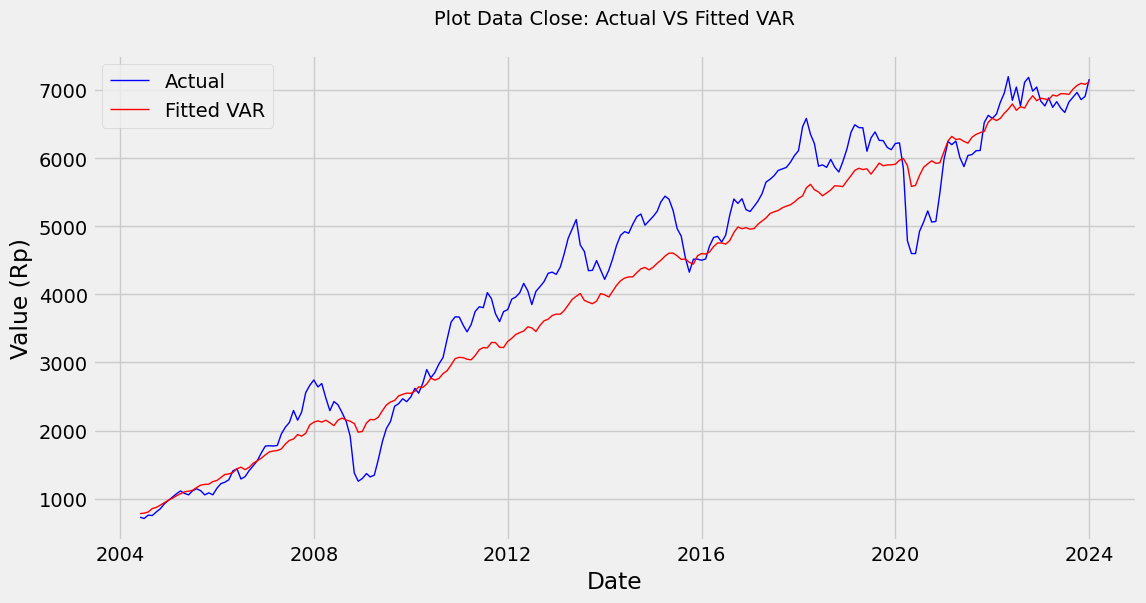

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(valid_data['Close Actual'], color='blue', linewidth=1, label='Actual')
plt.plot(valid_data['Close Fitted'], color='red', linewidth=1, label='Fitted VAR')
plt.xlabel('Date')
plt.ylabel('Value (Rp)')
plt.title('Plot Data Close: Actual VS Fitted VAR\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

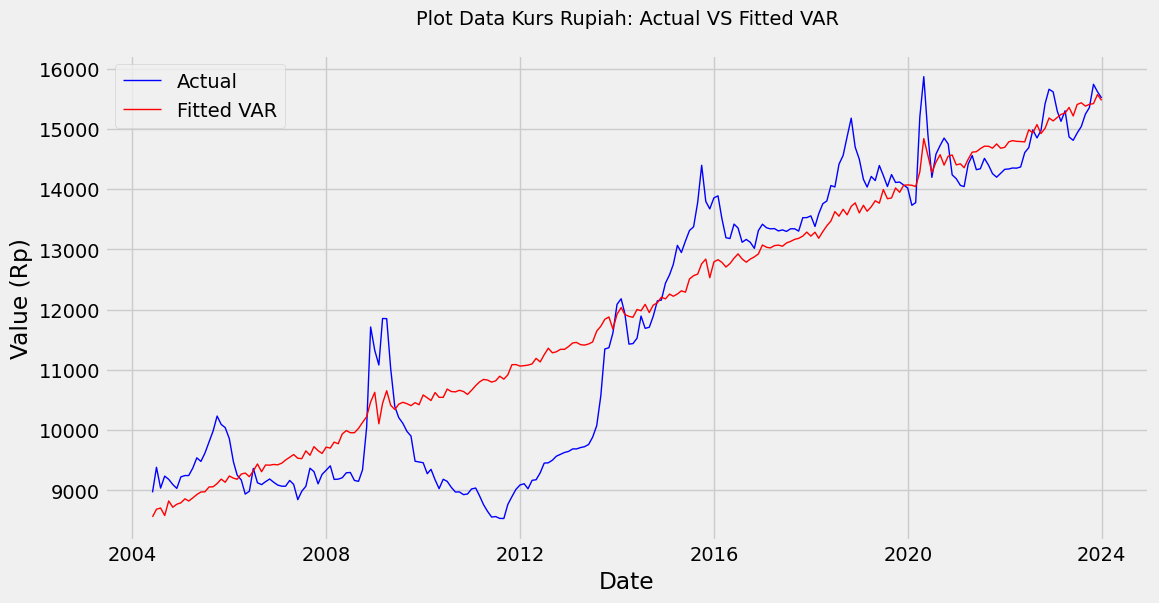

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(valid_data['Kurs Dollar Actual'], color='blue', linewidth=1, label='Actual')
plt.plot(valid_data['Kurs Dollar Fitted'], color='red', linewidth=1, label='Fitted VAR')
plt.xlabel('Date')
plt.ylabel('Value (Rp)')
plt.title('Plot Data Kurs Rupiah: Actual VS Fitted VAR\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

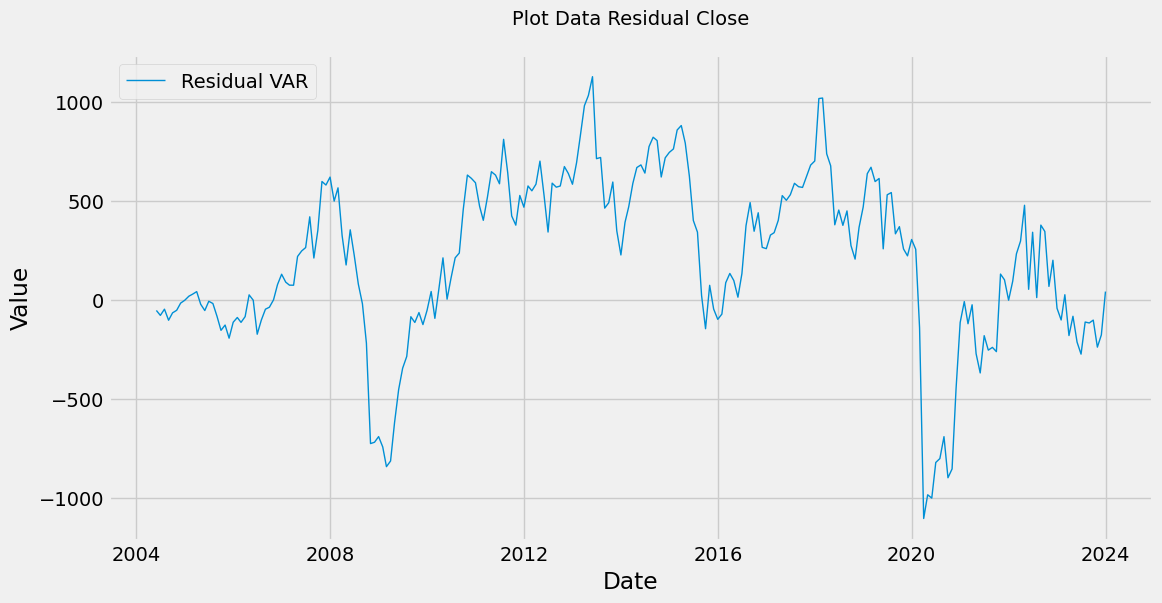

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(valid_data['Close Residual'], linewidth=1, label='Residual VAR')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Plot Data Residual Close\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

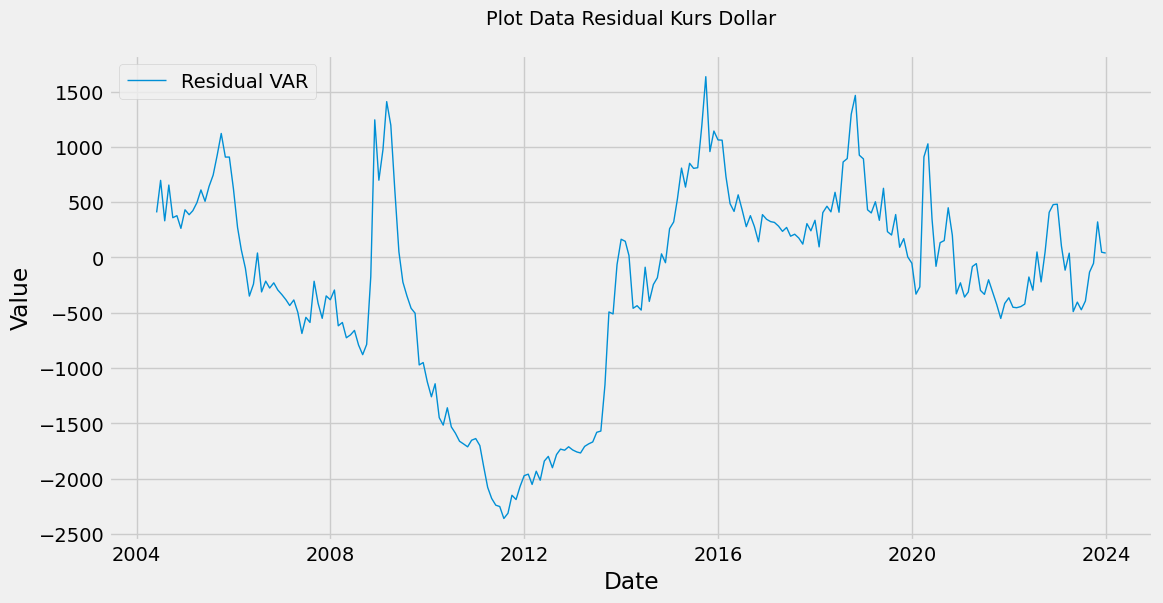

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(valid_data['Kurs Dollar Residual'], linewidth=1, label='Residual VAR')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Plot Data Residual Kurs Dollar\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## Forecasting

In [ ]:
forecast_steps = 7
forecast = fitted_model.forecast(data_diff.values[-fitted_model.k_ar:], steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, columns=['Close Forecast', 'Kurs Dollar Forecast'])

# Convert differenced forecast back to original scale
last_values = data.iloc[-1]
forecast_df['Close Forecast'] = forecast_df['Close Forecast'].cumsum() + last_values['Close']
forecast_df['Kurs Dollar Forecast'] = forecast_df['Kurs Dollar Forecast'].cumsum() + last_values['Kurs Dollar']
forecast_df.index = df_update.index

In [ ]:
df_forecast = pd.merge(df_update, forecast_df, left_index=True, right_index=True)
df_forecast

,Close,Kurs Dollar,Close Forecast,Kurs Dollar Forecast
Date,,,,
2024-01-31,7238.07,15610.82,7269.05,15535.73
2024-02-29,7284.16,15665.33,7318.74,15561.97
2024-03-31,7339.20,15702.61,7329.97,15599.68
2024-04-30,7165.03,16100.00,7344.44,15647.70
2024-05-31,7154.31,16083.94,7365.40,15684.61
2024-06-30,6904.72,16329.39,7392.62,15710.49
2024-07-31,7257.83,16261.65,7421.29,15738.08


In [ ]:
# Define true and predicted 'Close' values
y_true = df_forecast['Close']
y_pred = df_forecast['Close Forecast']

# Calculate MAE for 'Close' predictions
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE) for VAR Close: {mae}")

Mean Absolute Error (MAE) for VAR Close: 159.52074319386378


In [ ]:
# Define true and predicted 'Kurs Dollar' values
y_true = df_forecast['Kurs Dollar']
y_pred = df_forecast['Kurs Dollar Forecast']

# Calculate MAE for 'Kurs Dollar' predictions
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE) for VAR Kurs Dollar: {mae}")

Mean Absolute Error (MAE) for VAR Kurs Dollar: 325.0678383153567


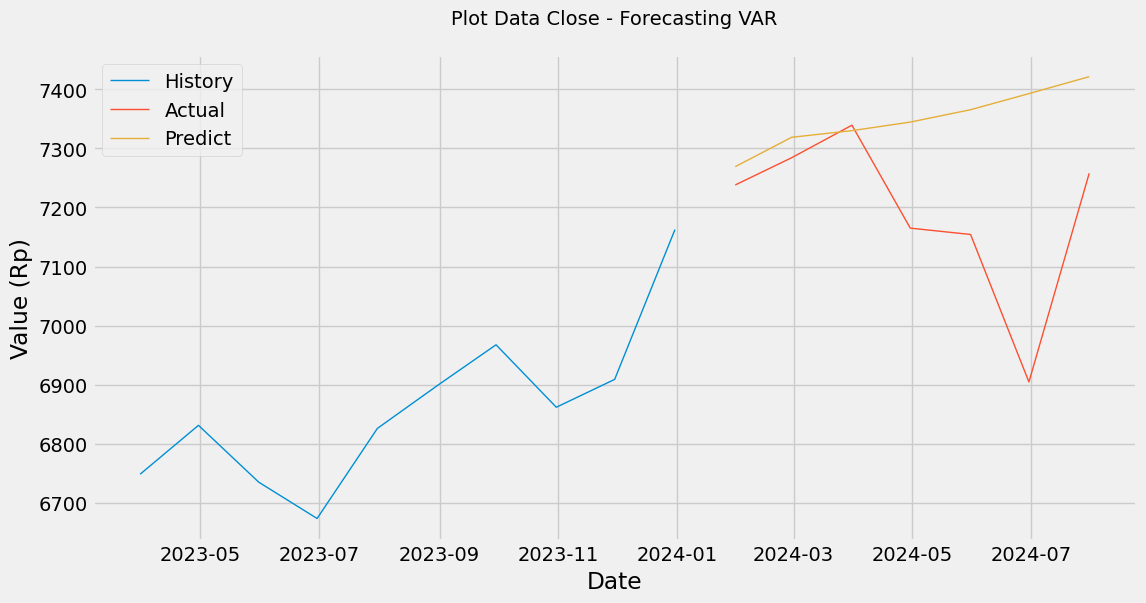

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(df_final.iloc[-10:]['Close'], linewidth=1, label='History')
plt.plot(df_forecast['Close'], linewidth=1, label='Actual')
plt.plot(df_forecast['Close Forecast'], linewidth=1, label='Predict')
plt.xlabel('Date')
plt.ylabel('Value (Rp)')
plt.title('Plot Data Close - Forecasting VAR\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

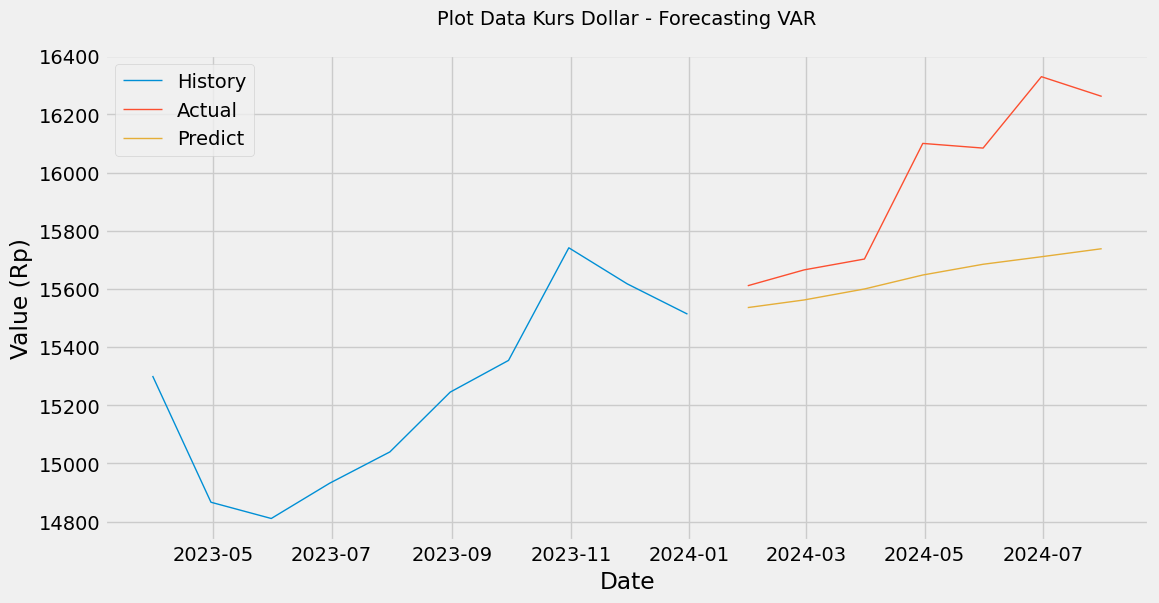

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(df_final.iloc[-10:]['Kurs Dollar'], linewidth=1, label='History')
plt.plot(df_forecast['Kurs Dollar'], linewidth=1, label='Actual')
plt.plot(df_forecast['Kurs Dollar Forecast'], linewidth=1, label='Predict')
plt.xlabel('Date')
plt.ylabel('Value (Rp)')
plt.title('Plot Data Kurs Dollar - Forecasting VAR\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# B. LONG SHORT TERM MEMMORY

## Splitting & Scaling

In [ ]:
# Select only the 'Kurs Dollar' column for input and output
df_residual = valid_data['Kurs Dollar Residual']
data2 = df_residual.copy()
data2

,Kurs Dollar Residual
Date,
2004-05-31,406.68
2004-06-30,696.78
2004-07-31,331.02
2004-08-31,654.31
2004-09-30,359.06
...,...
2023-08-31,-133.30
2023-09-30,-53.97
2023-10-31,321.11


In [ ]:
# Rand seed
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
# Normalize the data for LSTM
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaled_data2 = scaler2.fit_transform(data2.values.reshape(-1, 1))

In [ ]:
# Prepare the dataset for LSTM
def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]  # Use only the first column
        dataX.append(a)
        dataY.append(data[i + time_step, 0])  # Use only the first column
    return np.array(dataX), np.array(dataY)

In [ ]:
# Set the time step
time_step = 15

# Create the dataset for LSTM
X2, y2 = create_dataset(scaled_data2, time_step)

# Reshape X2 to be [samples, time steps, features] which is required for LSTM
X2 = X2.reshape(X2.shape[0], X2.shape[1], 1)

In [ ]:
# Split the data into training and testing sets for LSTM
train_size2 = int(len(X2) * 0.8)
test_size2 = len(X2) - train_size2
X2_train, X2_test = X2[:train_size2], X2[train_size2:]
y2_train, y2_test = y2[:train_size2], y2[train_size2:]

## Hypertuning Parameters

In [ ]:
# Function to create model for LSTM
def create_model_lstm2(units1, units2, dropout_rate, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units1, return_sequences=True, input_shape=(time_step, 1)))
    model.add(Dropout(rate=dropout_rate))
    model.add(LSTM(units=units2))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation='linear'))  # Single output
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [ ]:
# Define the hyperparameter grid for LSTM
param_grid_lstm2 = {
    'units1': [50, 100],
    'units2': [50, 100],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.01, 0.001],
    'batch_size': [32],
    'epochs': [50, 100]
}

In [ ]:
from itertools import product
# Convert param_grid to a list of dictionaries
param_list_lstm2 = list(product(param_grid_lstm2['units1'],
                                param_grid_lstm2['units2'],
                                param_grid_lstm2['dropout_rate'],
                                param_grid_lstm2['learning_rate'],
                                param_grid_lstm2['batch_size'],
                                param_grid_lstm2['epochs']))

In [ ]:
# Initialize variables to track the best model and the best score for LSTM2
best_score_lstm2 = float('inf')
best_params_lstm2 = None
best_model_lstm2 = None

# Perform manual grid search for LSTM
for params in param_list_lstm2:
    units1, units2, dropout_rate, learning_rate, batch_size, epochs = params

    print(f"Training LSTM model with parameters: units1={units1}, units2={units2}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")

    model_lstm2 = create_model_lstm2(units1, units2, dropout_rate, learning_rate)

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history_lstm2 = model_lstm2.fit(X2_train, y2_train, batch_size=batch_size, epochs=epochs, validation_data=(X2_test, y2_test), callbacks=[early_stopping], verbose=0)

    val_loss = min(history_lstm2.history['val_loss'])

    if val_loss < best_score_lstm2:
        best_score_lstm2 = val_loss
        best_params_lstm2 = {
            'units1': units1,
            'units2': units2,
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'epochs': epochs
        }
        best_model_lstm2 = model_lstm2

print(f"Best LSTM score: {best_score_lstm2} with parameters: {best_params_lstm2}")

Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0.2, learning_rate=0.01, batch_size=32, epochs=50
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0.2, learning_rate=0.01, batch_size=32, epochs=100
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0.2, learning_rate=0.001, batch_size=32, epochs=50
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0.2, learning_rate=0.001, batch_size=32, epochs=100
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0.3, learning_rate=0.01, batch_size=32, epochs=50
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0.3, learning_rate=0.01, batch_size=32, epochs=100
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0.3, learning_rate=0.001, batch_size=32, epochs=50
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0.3, learning_rate=0.001, batch_size=32, epochs=100
Training LSTM mo

## Model

In [ ]:

manual_units1_lstm2 = best_params_lstm2['units1']
manual_units2_lstm2 = best_params_lstm2['units2']
manual_dropout_rate_lstm2 = best_params_lstm2['dropout_rate']
manual_learning_rate_lstm2 = best_params_lstm2['learning_rate']
manual_batch_size_lstm2 = best_params_lstm2['batch_size']
manual_epochs_lstm2 = best_params_lstm2['epochs']

# Train the LSTM model with best parameters
model_manual_lstm2 = create_model_lstm2(manual_units1_lstm2,
                                        manual_units2_lstm2,
                                        manual_dropout_rate_lstm2,
                                        manual_learning_rate_lstm2)

# Early stopping callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=50,
                               restore_best_weights=True)

# Train the manually specified LSTM model
history_manual_lstm2 = model_manual_lstm2.fit(X2_train,
                                              y2_train,
                                              batch_size=manual_batch_size_lstm2,
                                              epochs=manual_epochs_lstm2,
                                              validation_data=(X2_test, y2_test),
                                              callbacks=[early_stopping],
                                              verbose=1)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 0.3884 - val_loss: 0.0084
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0666 - val_loss: 0.0632
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0549 - val_loss: 0.0252
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0388 - val_loss: 0.0172
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0303 - val_loss: 0.0103
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0238 - val_loss: 0.0092
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0179 - val_loss: 0.0107
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0159 - val_loss: 0.0090
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0158 - val_loss: 0.0085
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0133 - val_loss: 0.0072
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0109 - val_loss: 0.0065
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0108 - val_loss: 0.0063


In [ ]:
# Summary model
model_manual_lstm2.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_64 (LSTM)                       │ (None, 15, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ (None, 15, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_65 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_65 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 363,905 (1.39 MB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 242,604 (947.68 KB)

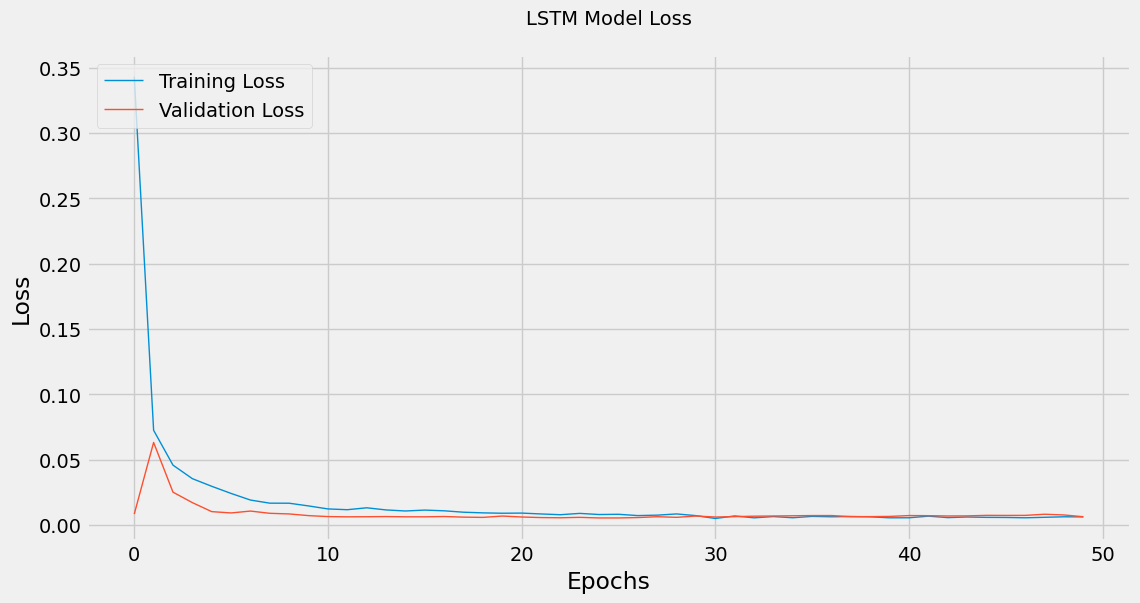

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(history_manual_lstm2.history['loss'], label='Training Loss', linewidth=1)
plt.plot(history_manual_lstm2.history['val_loss'], label='Validation Loss', linewidth=1)
plt.title('LSTM Model Loss\n', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Loss\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# Predict on the training data for LSTM
train_predict_lstm2 = model_manual_lstm2.predict(X2_train)
test_predict_lstm2 = model_manual_lstm2.predict(X2_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [ ]:
# Inverse transform the predictions for LSTM
train_predict_lstm2 = scaler2.inverse_transform(train_predict_lstm2)
test_predict_lstm2 = scaler2.inverse_transform(test_predict_lstm2)
y2_train = scaler2.inverse_transform(y2_train.reshape(-1, 1))
y2_test = scaler2.inverse_transform(y2_test.reshape(-1, 1))

## Evaluation & Visualization

In [ ]:
# Calculate MAE for LSTM
train_mae_kurs_lstm2 = mean_absolute_error(y2_train, train_predict_lstm2)
test_mae_kurs_lstm2 = mean_absolute_error(y2_test, test_predict_lstm2)

print(f'Training MAE (Kurs Dollar) LSTM: {train_mae_kurs_lstm2:.4f}')
print(f'Testing MAE (Kurs Dollar) LSTM: {test_mae_kurs_lstm2:.4f}')

Training MAE (Kurs Dollar) LSTM: 214.9369
Testing MAE (Kurs Dollar) LSTM: 229.7898


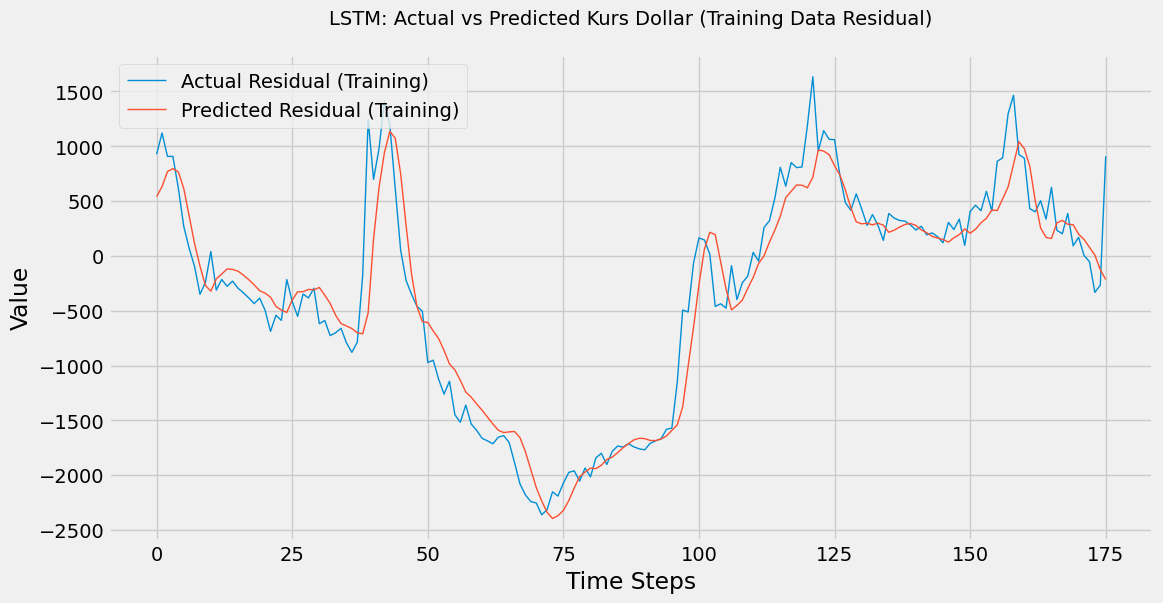

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(y2_train, label='Actual Residual (Training)', linewidth=1)
plt.plot(train_predict_lstm2, label='Predicted Residual (Training)', linewidth=1)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('LSTM: Actual vs Predicted Kurs Dollar (Training Data Residual)\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

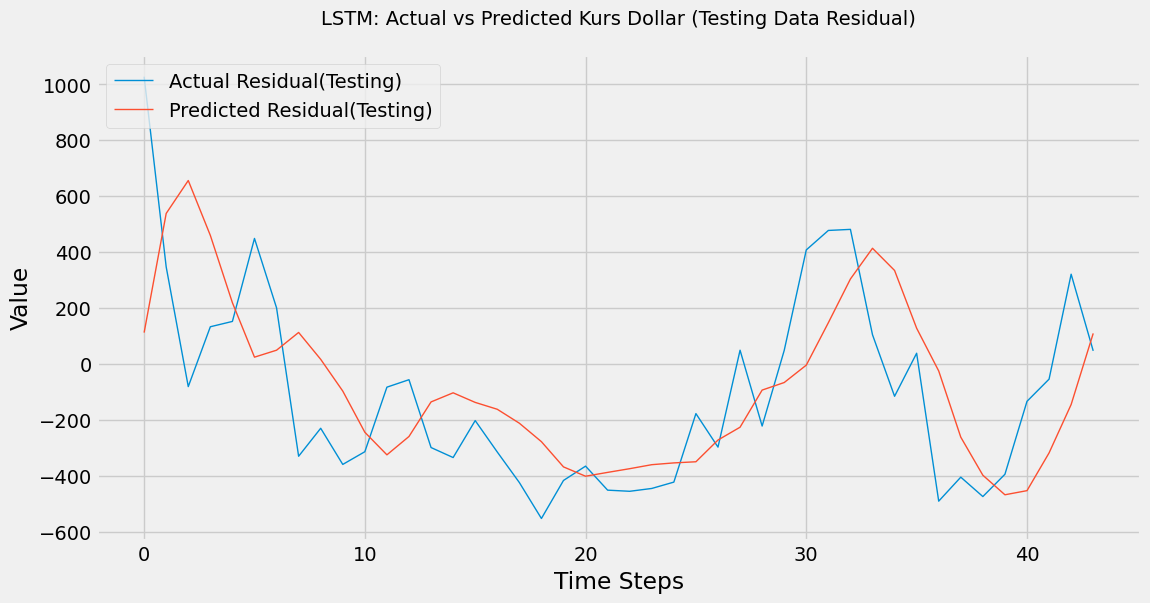

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(y2_test, label='Actual Residual(Testing)', linewidth=1)
plt.plot(test_predict_lstm2, label='Predicted Residual(Testing)', linewidth=1)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('LSTM: Actual vs Predicted Kurs Dollar (Testing Data Residual)\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## Forecasting



In [ ]:
# Forecasting for the next steps
predictions_lstm2 = []

# Prepare the input data for forecasting
input_data_lstm2 = scaled_data2[-time_step:].reshape(1, time_step, 1)

# Loop to predict the next steps
for _ in range(7):
    pred = model_manual_lstm2.predict(input_data_lstm2)
    predictions_lstm2.append(pred[0])
    input_data_lstm2 = np.append(input_data_lstm2[:, 1:, :], [[pred[0]]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [ ]:
# Inverse transform the predictions to original scale
predictions_lstm2 = scaler2.inverse_transform(predictions_lstm2)

# Save predictions to DataFrame
df_future_predictions_lstm2 = pd.DataFrame(predictions_lstm2, columns=['Predicted Residual Kurs Dollar'])

# Assuming df_update is the dataframe where you want to align future predictions, here aligning index with the valid_data's last 7 steps.
df_future_predictions_lstm2.index = df_update.index

# Display the future predictions DataFrame
df_future_predictions_lstm2

,Predicted Residual Kurs Dollar
Date,
2024-01-31,206.43
2024-02-29,189.26
2024-03-31,155.75
2024-04-30,126.58
2024-05-31,104.89
2024-06-30,84.47
2024-07-31,63.50


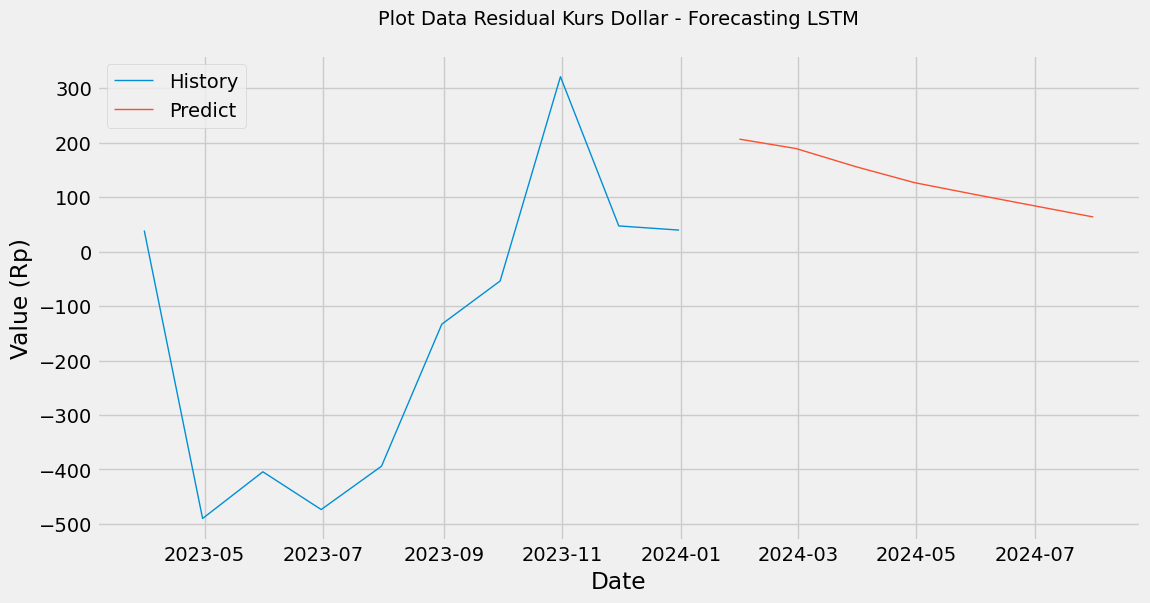

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(valid_data.iloc[-10:]['Kurs Dollar Residual'], linewidth=1, label='History')
plt.plot(df_future_predictions_lstm2['Predicted Residual Kurs Dollar'], linewidth=1, label='Predict')
plt.xlabel('Date')
plt.ylabel('Value (Rp)')
plt.title('Plot Data Residual Kurs Dollar - Forecasting LSTM\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# C. HYBRID VAR-LSTM

## Model

In [ ]:
df_linear = df_forecast[['Kurs Dollar Forecast']]
df_linear

,Kurs Dollar Forecast
Date,
2024-01-31,15535.73
2024-02-29,15561.97
2024-03-31,15599.68
2024-04-30,15647.70
2024-05-31,15684.61
2024-06-30,15710.49
2024-07-31,15738.08


In [ ]:
df_nonlinear = df_future_predictions_lstm2.copy()
df_nonlinear

,Predicted Residual Kurs Dollar
Date,
2024-01-31,206.43
2024-02-29,189.26
2024-03-31,155.75
2024-04-30,126.58
2024-05-31,104.89
2024-06-30,84.47
2024-07-31,63.50


In [ ]:
df_hybrid = pd.DataFrame({
    'Hybrid Kurs Dollar': df_linear['Kurs Dollar Forecast'] + df_nonlinear['Predicted Residual Kurs Dollar'],
})
df_hybrid

,Hybrid Kurs Dollar
Date,
2024-01-31,15742.16
2024-02-29,15751.23
2024-03-31,15755.43
2024-04-30,15774.28
2024-05-31,15789.50
2024-06-30,15794.96
2024-07-31,15801.59


In [ ]:
df_hybrid_final = pd.merge(df_update['Kurs Dollar'], df_hybrid, left_index=True, right_index=True)
print(df_hybrid_final.shape)
df_hybrid_final

(7, 2)


,Kurs Dollar,Hybrid Kurs Dollar
Date,,
2024-01-31,15610.82,15742.16
2024-02-29,15665.33,15751.23
2024-03-31,15702.61,15755.43
2024-04-30,16100.00,15774.28
2024-05-31,16083.94,15789.50
2024-06-30,16329.39,15794.96
2024-07-31,16261.65,15801.59


## Evaluation & Visualization

In [ ]:
# Define true and predicted 'Close' values
y_true = df_hybrid_final['Kurs Dollar']
y_pred = df_hybrid_final['Hybrid Kurs Dollar']

# Calculate MAE for 'Close' predictions
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE) for Hybrid Kurs Dollar: {mae}")

Mean Absolute Error (MAE) for Hybrid Kurs Dollar: 269.24639021088973


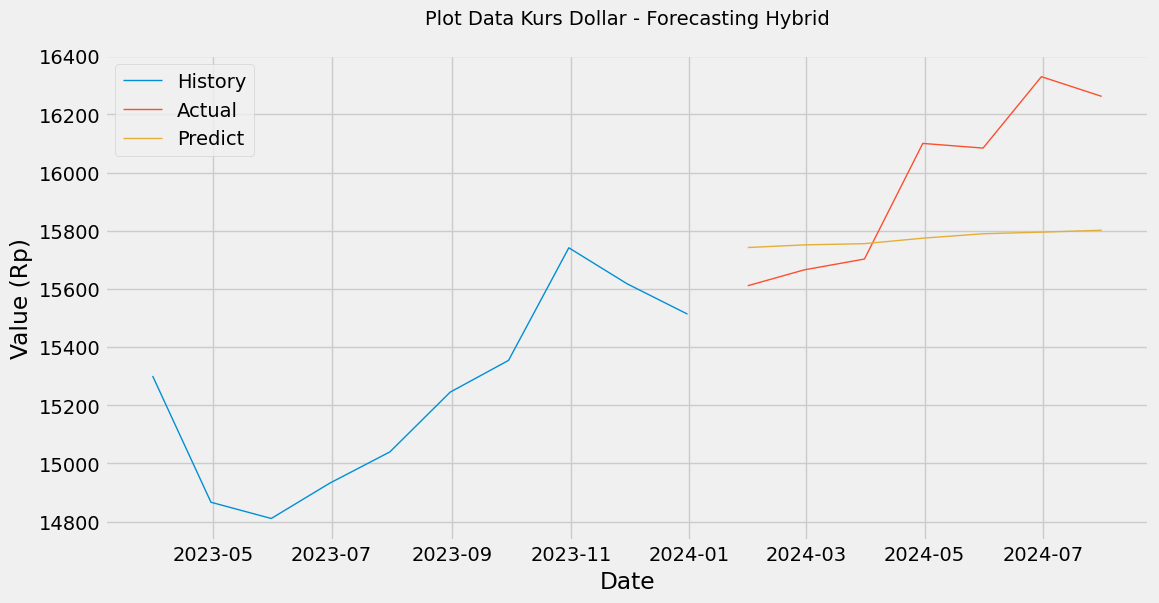

In [ ]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(df_final.iloc[-10:]['Kurs Dollar'], linewidth=1, label='History')
plt.plot(df_hybrid_final['Kurs Dollar'], linewidth=1, label='Actual')
plt.plot(df_hybrid_final['Hybrid Kurs Dollar'], linewidth=1, label='Predict')
plt.xlabel('Date')
plt.ylabel('Value (Rp)')
plt.title('Plot Data Kurs Dollar - Forecasting Hybrid\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()